# Hourly PSDS - FFBI & ROMY (U,V,Z)

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average
from functions.get_median_psd import __get_median_psd

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
# !ls /home/andbro/kilauea-data/VelocityChanges/data/PSDS/RLAS_ROMY_coh/

In [15]:
config = {}


config['station'] = "ROMY"

config['d1'], config['d2'] = "2023-09-23", "2023-10-23"

config['path_to_data'] = data_path+f"VelocityChanges/data/PSDS/"

config['outpath_figures'] = data_path+f"VelocityChanges/figures/"

config['frequency_limits'] = 1e-3, 1e1


## Methods

In [7]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [8]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    out = read_pickle(path+file)

    psds_hourly = out['psd']
    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [9]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [10]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [11]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    ##____________________________

    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    axes.set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

In [12]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, log10
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 5

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                if j == 3:
                    axes[j].plot(ff[j], psd, color=colors[n], alpha=0.7)
                    p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)
                else:
                    axes[j].plot(ff[j], psd, color=colors[n], alpha=0.7)
                    p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].plot(ff[j], reject, color='grey', alpha=0.6, zorder=2)

        except Exception as e:
            print(e)
            pass

        if j == 5:
            axes[j].plot(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")
        else:
            axes[j].plot(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[j].set_xlim(config['frequency_limits'][0], config['frequency_limits'][1])
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)
        axes[j].set_xscale("log")

    axes[0].set_yscale("log")
    axes[1].set_yscale("log")
    # axes[3].set_yscale("log")

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(c)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)
    axes[4].text(.01, .95, '(c)', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    axes[0].text(.05, .95, f'ROMY-Z', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.05, .95, f'RLAS-Z', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.05, .95, f'Coherence', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.05, .95, f'Cross-Spectral Density', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)
    axes[4].text(.05, .95, f'Cross-Wavelet Transform', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23, top=1e-17)
    axes[1].set_ylim(bottom=1e-23, top=1e-17)
    # axes[2].set_ylim(bottom=0, top=1)
    # axes[3].set_ylim(bottom=-300, top=100)

    axes[0].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"Coherence", fontsize=font)
    axes[3].set_ylabel(r"CSD (dB)", fontsize=font)
    axes[4].set_ylabel(r"Cross Power", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

In [17]:
def __get_fband_averages(_ff, _psds):

    psds = []
    for _n, _psd in enumerate(_psds):
        out0 = __get_fband_average(_ff, _psd, faction_of_octave=12 , average="median", plot=False)
        psds.append(out0['psd_means'])

    ff = out0['fcenter']
    psds = array(psds)

    return ff, psds

## RUN for all files 

 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


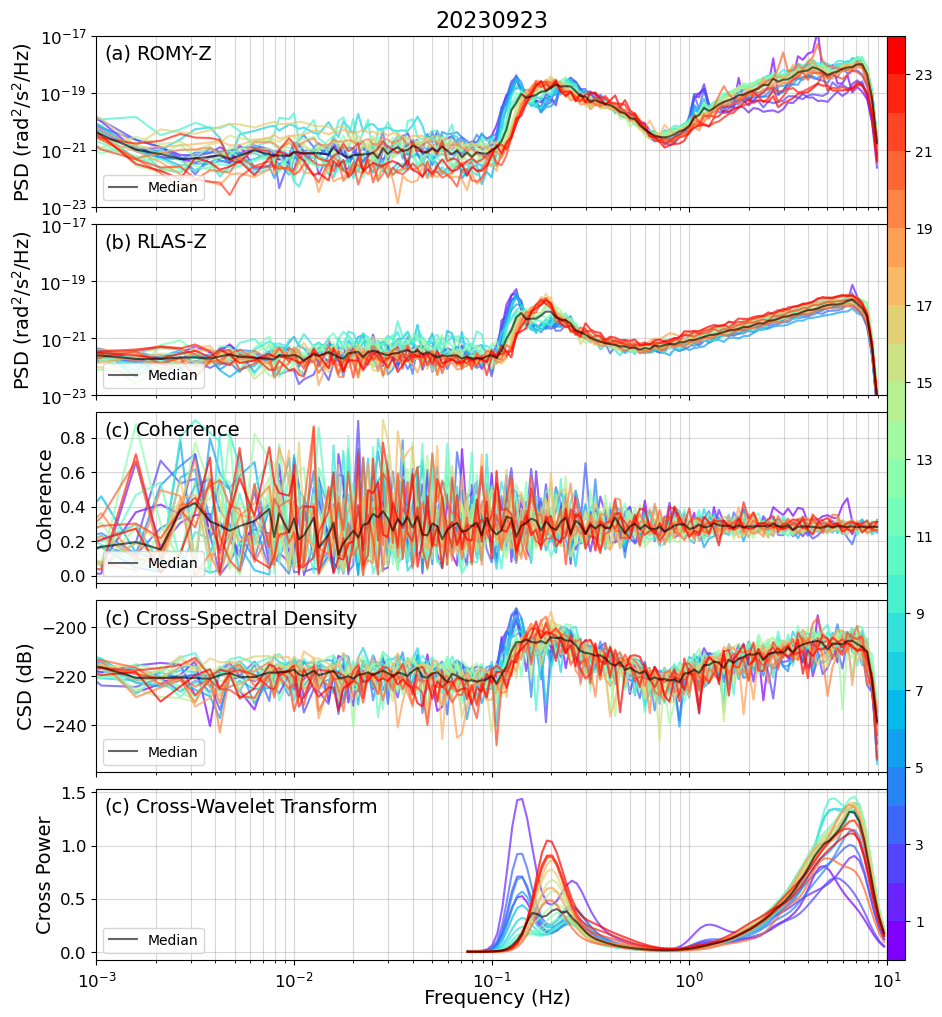

In [18]:
psds_medians_out, times_out = [], []

for _i, day in enumerate(date_range(config['d1'], config['d2'])):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    year = day[:4]

    if _i > 0:
        continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {file} ...")
    #     continue


    try:

        ## Data1 --------------------------
        name = f"ROMY/{year}_ROMY_Z"

        out = read_pickle(config['path_to_data']+f"{name}_3600_{day}_hourly.pkl")
        ff1 = out['frequencies']
        dat1 = out['psd']

        dat1, rejected_dat1 = __remove_noisy_psds(dat1, threshold_mean=1e-19, ff=ff1, flim=0.05)
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])
        ff1, dat1 = __get_fband_averages(ff1, dat1)


        ## Data2 --------------------------
        name = f"RLAS/{year}_RLAS"

        out = read_pickle(config['path_to_data']+f"{name}_3600_{day}_hourly.pkl")
        ff2 = out['frequencies']
        dat2 = out['psd']

        dat2, rejected_dat2 = __remove_noisy_psds(dat2, threshold_mean=1e-20, ff=ff1, flim=0.05)
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])
        ff2, dat2 = __get_fband_averages(ff2, dat2)


        ## Data3 --------------------------
        name = f"RLAS_ROMY_coh/{year}_RLAS_ROMY_coh"

        out = read_pickle(config['path_to_data']+f"{name}_3600_{day}_hourly.pkl")
        ff3 = out['frequencies']
        dat3 = out['coherence']

        dat3, rejected_dat3 = __remove_noisy_psds(dat3, threshold_mean=2, ff=ff1, flim=0.05)
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])
        ff3, dat3 = __get_fband_averages(ff3, dat3)


        ## Data4 --------------------------
        name = f"RLAS_ROMY_csd/{year}_RLAS_ROMY_csd"

        out = read_pickle(config['path_to_data']+f"{name}_3600_{day}_hourly.pkl")
        ff4 = out['frequencies']
        dat4 = out['csd']

        dat4, rejected_dat4 = __remove_noisy_psds(dat4, threshold_mean=1, ff=ff1, flim=0.05)
        # dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])
        ff4, dat4 = __get_fband_averages(ff4, dat4)

        dat4 = array([10*log10(abs(dd)) for dd in dat4])


        ## Data5 --------------------------
        name = f"RLAS_ROMY_xwt/{year}_RLAS_ROMY_xwt"

        out = read_pickle(config['path_to_data']+f"{name}_3600_{day}_hourly.pkl")
        ff5 = out['frequencies']
        dat5 = out['xwt']

        rejected_dat5 = dat5*0


    except Exception as e:
        print(e)
        continue


    fig = __makeplot_colorlines_overview(config,
                                         [ff1, ff2, ff3, ff4, ff5],
                                         [dat1, dat2, dat3, dat4, dat5],
                                         [rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                         day,
                                         show_rejected=False)

    # print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    # fig.savefig(config['outpath_figures']+"joint_RLAS_ROMY/"+config['outpath_figname']+"_ROMY.png", format="png", transparent=False, bbox_inches='tight', dpi=200)


In [ ]:
## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)